## Import Modules

In [1]:
import os
from IPython.display import clear_output
import glob
import torch
from torch import optim
print('cuda available: '+ str(torch.cuda.is_available()))

from models_avm import NestedUNet, UNet
from loss_fun_avm import compute_per_channel_dice, DiceLoss, FocalLoss
from tra_val_avm import train, validation
from data_loader_avm import Dataset

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda available: True


## Data Path

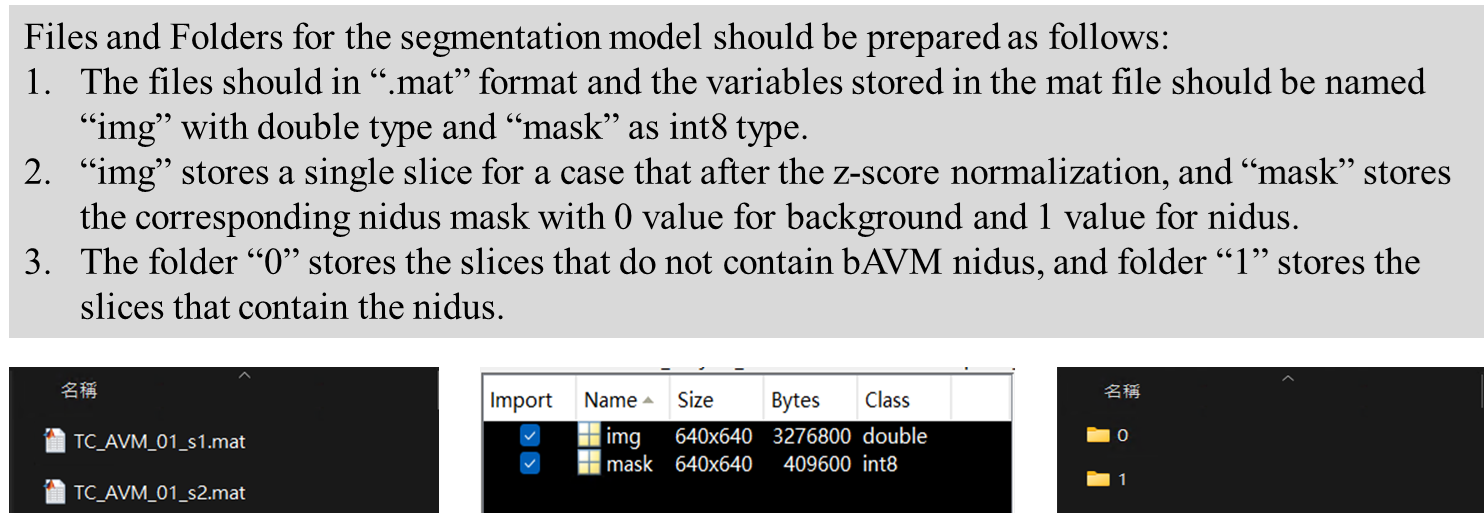

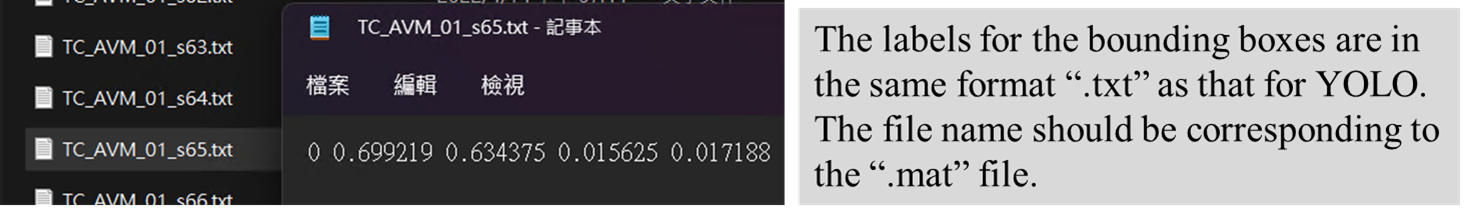

In [2]:
# Define data list here
# The files for training should be those slices with the bAVM.

path_tra1 = r'E:\AVM_Project_TCVGH\Datasets\prc\6_Datasets_for_model_fin2D\forUNetpp\1_tra\1' #mod
list_tra1 = os.listdir(path_tra1)
for i in range(len(list_tra1)):
    list_tra1[i] = path_tra1+'/'+list_tra1[i]    
list_tra = list_tra1
    
path_val1 = r'E:\AVM_Project_TCVGH\Datasets\prc\6_Datasets_for_model_fin2D\forUNetpp\2_val\1' #mod
list_val1 = os.listdir(path_val1)
for i in range(len(list_val1)):
    list_val1[i] = path_val1+'/'+list_val1[i]    
list_val = list_val1

path_ts1 = r'E:\AVM_Project_TCVGH\Datasets\prc\6_Datasets_for_model_fin2D\forUNetpp\3_ts\1' #mod
list_ts1 = os.listdir(path_ts1)
for i in range(len(list_ts1)):
    list_ts1[i] = path_ts1+'/'+list_ts1[i]    
list_ts = list_ts1

# The labels in YOLO format for the bounding boxes
path_tra_lab_txt = r'E:\AVM_Project_TCVGH\Datasets\prc\6_Datasets_for_model_fin2D\forYOLOv5\labels\1_tra' #mod
path_val_lab_txt = r'E:\AVM_Project_TCVGH\Datasets\prc\6_Datasets_for_model_fin2D\forYOLOv5\labels\2_val' #mod
path_ts_lab_txt = r'E:\AVM_Project_TCVGH\Datasets\prc\6_Datasets_for_model_fin2D\forYOLOv5\labels\3_ts' #mod

## Data Loader

In [4]:
# Define the dataloader
# The argument "rand_dilate" defines whether to have the random dilation for the bounding box during training.
# The argument "max_dilate_factor" defines the pixel number for the random dilation.
# For example, the following code is the dataset with random dilation of 10 pixels during training:
# train_data = Dataset(list_tra,path_tra_lab_txt,rand_dilate=True,max_dilate_factor=10)
# The following code is the dataset with no random dilation during training:
#  train_data = Dataset(list_tra,path_tra_lab_txt,rand_dilate=False)

train_data = Dataset(list_tra,path_tra_lab_txt,rand_dilate=True,max_dilate_factor=10) #mod
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size = 12,
    shuffle = True,   
    num_workers = 4   
)

val_data = Dataset(list_val,path_val_lab_txt,rand_dilate=True,max_dilate_factor=10) #mod
val_loader = torch.utils.data.DataLoader(
    dataset = val_data,           
    batch_size = 12,                 
    shuffle = False,   
    num_workers = 4              
)

## Initialize Model and Optimization Parameters

In [5]:
# call model cuda for gpu
#model = UNet(norm_method='group').cuda()
model = NestedUNet(norm_method='group').cuda() #mod

# define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.95)

# loss function
kwargs = {"alpha": 0.5, "gamma": 3, "reduction": 'mean'}
criterion_FL = FocalLoss(**kwargs)
criterion_DICE = DiceLoss()
loss = [criterion_FL,criterion_DICE]

## Start to Train

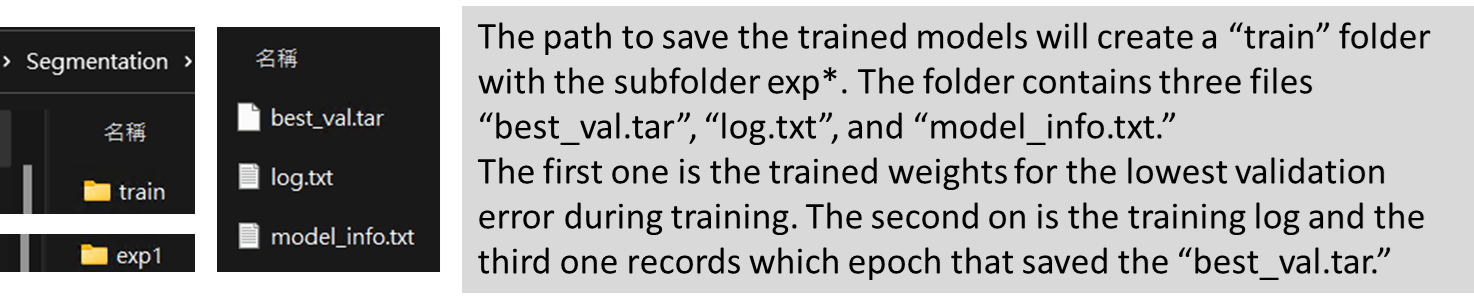

In [6]:
# Define the directory for saving the trained model
# The "path" defines where the trained model is saved.
path = r'C:\Users\USER\Desktop\Segmentation\Models\unetpp\Models\Seg_dia10' #mod

if os.path.isdir(path)==False:
    os.mkdir(path)
path = os.path.join(path,"train")
if os.path.isdir(path)==False:
    os.mkdir(path)       
filenum = glob.glob(path + "/exp*")
path = path + "/exp" + str(len(filenum)+1)
os.mkdir(path)

# Train the Model
epochs = 100 # The number of epochs

valloss = 0
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(path=path,
          model=model,
          loss=loss,
          optimizer=optimizer,
          dataloader=train_loader,
          epoch=epoch,
          scheduler=scheduler)
    print('-' * 89)
    vallossnew = validation(path=path,
          model=model,
          loss=loss,
          dataloader=val_loader,
          epoch=epoch)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
    print('-' * 89)
    
    scheduler.step()
    
    f2 = open(path + '/model_info.txt', 'a')
    if vallossnew<valloss or epoch ==1: 
        fname = path + '/best_val'  + '.tar'
        torch.save(model.state_dict(), fname)
        valloss = vallossnew
        f2.write('| best_val | epoch {:3d}| '.format(epoch)+'\r\n')        
    f2.close()
    

| epoch   1 |   100/  290 batches | lr 0.0001000 | ms/batch 44114.62 | loss_fl 0.026718 | loss_dice  0.37 | 
| epoch   1 |   200/  290 batches | lr 0.0001000 | ms/batch 42626.95 | loss_fl 0.017945 | loss_dice  0.26 | 
| epoch   1 |   290/  290 batches | lr 0.0001000 | ms/batch 36175.46 | loss_fl 0.014356 | loss_dice  0.22 | 
-----------------------------------------------------------------------------------------
| epoch   1 |    40/   40 batches | | ms/batch 8081.05 | val_loss_fl 0.005384 | val_loss_dice  0.14 | 
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 131.09s
-----------------------------------------------------------------------------------------
| epoch   2 |   100/  290 batches | lr 0.0001000 | ms/batch 42846.90 | loss_fl 0.004668 | loss_dice  0.12 | 
| epoch   2 |   200/  290 batches | lr 0.0001000 | ms/batch 41700.00 | loss_fl 0.004113 | loss_dice  0.12 | 
| epoch   2 |   290/  290 batches | lr 0.000100

| epoch  12 |   200/  290 batches | lr 0.0000950 | ms/batch 42519.08 | loss_fl 0.000321 | loss_dice  0.09 | 
| epoch  12 |   290/  290 batches | lr 0.0000950 | ms/batch 37220.89 | loss_fl 0.000319 | loss_dice  0.09 | 
-----------------------------------------------------------------------------------------
| epoch  12 |    40/   40 batches | | ms/batch 8477.64 | val_loss_fl 0.000414 | val_loss_dice  0.10 | 
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 132.60s
-----------------------------------------------------------------------------------------
| epoch  13 |   100/  290 batches | lr 0.0000950 | ms/batch 43513.18 | loss_fl 0.000317 | loss_dice  0.10 | 
| epoch  13 |   200/  290 batches | lr 0.0000950 | ms/batch 42860.98 | loss_fl 0.000306 | loss_dice  0.09 | 
| epoch  13 |   290/  290 batches | lr 0.0000950 | ms/batch 37671.86 | loss_fl 0.000302 | loss_dice  0.09 | 
-----------------------------------------------

| epoch  23 |   290/  290 batches | lr 0.0000902 | ms/batch 37651.61 | loss_fl 0.000253 | loss_dice  0.09 | 
-----------------------------------------------------------------------------------------
| epoch  23 |    40/   40 batches | | ms/batch 9132.82 | val_loss_fl 0.000386 | val_loss_dice  0.10 | 
-----------------------------------------------------------------------------------------
| end of epoch  23 | time: 132.52s
-----------------------------------------------------------------------------------------
| epoch  24 |   100/  290 batches | lr 0.0000902 | ms/batch 43588.95 | loss_fl 0.000261 | loss_dice  0.09 | 
| epoch  24 |   200/  290 batches | lr 0.0000902 | ms/batch 42346.11 | loss_fl 0.000247 | loss_dice  0.09 | 
| epoch  24 |   290/  290 batches | lr 0.0000902 | ms/batch 37661.78 | loss_fl 0.000243 | loss_dice  0.09 | 
-----------------------------------------------------------------------------------------
| epoch  24 |    40/   40 batches | | ms/batch 8459.03 | val_loss_

| epoch  34 |    40/   40 batches | | ms/batch 8469.09 | val_loss_fl 0.000376 | val_loss_dice  0.09 | 
-----------------------------------------------------------------------------------------
| end of epoch  34 | time: 132.50s
-----------------------------------------------------------------------------------------
| epoch  35 |   100/  290 batches | lr 0.0000857 | ms/batch 43562.99 | loss_fl 0.000204 | loss_dice  0.07 | 
| epoch  35 |   200/  290 batches | lr 0.0000857 | ms/batch 42222.18 | loss_fl 0.000196 | loss_dice  0.07 | 
| epoch  35 |   290/  290 batches | lr 0.0000857 | ms/batch 37515.14 | loss_fl 0.000193 | loss_dice  0.07 | 
-----------------------------------------------------------------------------------------
| epoch  35 |    40/   40 batches | | ms/batch 8436.77 | val_loss_fl 0.000402 | val_loss_dice  0.08 | 
-----------------------------------------------------------------------------------------
| end of epoch  35 | time: 131.82s
-------------------------------------

| epoch  46 |   100/  290 batches | lr 0.0000815 | ms/batch 44051.09 | loss_fl 0.000155 | loss_dice  0.06 | 
| epoch  46 |   200/  290 batches | lr 0.0000815 | ms/batch 42991.08 | loss_fl 0.000156 | loss_dice  0.06 | 
| epoch  46 |   290/  290 batches | lr 0.0000815 | ms/batch 37396.73 | loss_fl 0.000155 | loss_dice  0.06 | 
-----------------------------------------------------------------------------------------
| epoch  46 |    40/   40 batches | | ms/batch 8485.03 | val_loss_fl 0.000485 | val_loss_dice  0.09 | 
-----------------------------------------------------------------------------------------
| end of epoch  46 | time: 133.00s
-----------------------------------------------------------------------------------------
| epoch  47 |   100/  290 batches | lr 0.0000815 | ms/batch 43846.53 | loss_fl 0.000150 | loss_dice  0.07 | 
| epoch  47 |   200/  290 batches | lr 0.0000815 | ms/batch 42660.63 | loss_fl 0.000150 | loss_dice  0.06 | 
| epoch  47 |   290/  290 batches | lr 0.000081

| epoch  57 |   200/  290 batches | lr 0.0000774 | ms/batch 42145.13 | loss_fl 0.000126 | loss_dice  0.05 | 
| epoch  57 |   290/  290 batches | lr 0.0000774 | ms/batch 37538.22 | loss_fl 0.000127 | loss_dice  0.05 | 
-----------------------------------------------------------------------------------------
| epoch  57 |    40/   40 batches | | ms/batch 8693.21 | val_loss_fl 0.000530 | val_loss_dice  0.08 | 
-----------------------------------------------------------------------------------------
| end of epoch  57 | time: 132.28s
-----------------------------------------------------------------------------------------
| epoch  58 |   100/  290 batches | lr 0.0000774 | ms/batch 43518.36 | loss_fl 0.000130 | loss_dice  0.05 | 
| epoch  58 |   200/  290 batches | lr 0.0000774 | ms/batch 42379.10 | loss_fl 0.000144 | loss_dice  0.06 | 
| epoch  58 |   290/  290 batches | lr 0.0000774 | ms/batch 37238.58 | loss_fl 0.000140 | loss_dice  0.06 | 
-----------------------------------------------

| epoch  68 |   290/  290 batches | lr 0.0000735 | ms/batch 37135.10 | loss_fl 0.000105 | loss_dice  0.05 | 
-----------------------------------------------------------------------------------------
| epoch  68 |    40/   40 batches | | ms/batch 8521.84 | val_loss_fl 0.000801 | val_loss_dice  0.08 | 
-----------------------------------------------------------------------------------------
| end of epoch  68 | time: 132.61s
-----------------------------------------------------------------------------------------
| epoch  69 |   100/  290 batches | lr 0.0000735 | ms/batch 43317.05 | loss_fl 0.000101 | loss_dice  0.05 | 
| epoch  69 |   200/  290 batches | lr 0.0000735 | ms/batch 42282.08 | loss_fl 0.000103 | loss_dice  0.05 | 
| epoch  69 |   290/  290 batches | lr 0.0000735 | ms/batch 37899.45 | loss_fl 0.000106 | loss_dice  0.05 | 
-----------------------------------------------------------------------------------------
| epoch  69 |    40/   40 batches | | ms/batch 8506.68 | val_loss_

| epoch  79 |    40/   40 batches | | ms/batch 8450.56 | val_loss_fl 0.000753 | val_loss_dice  0.09 | 
-----------------------------------------------------------------------------------------
| end of epoch  79 | time: 132.95s
-----------------------------------------------------------------------------------------
| epoch  80 |   100/  290 batches | lr 0.0000698 | ms/batch 43617.31 | loss_fl 0.000091 | loss_dice  0.04 | 
| epoch  80 |   200/  290 batches | lr 0.0000698 | ms/batch 42621.94 | loss_fl 0.000091 | loss_dice  0.04 | 
| epoch  80 |   290/  290 batches | lr 0.0000698 | ms/batch 37753.44 | loss_fl 0.000091 | loss_dice  0.04 | 
-----------------------------------------------------------------------------------------
| epoch  80 |    40/   40 batches | | ms/batch 8520.70 | val_loss_fl 0.000676 | val_loss_dice  0.09 | 
-----------------------------------------------------------------------------------------
| end of epoch  80 | time: 132.59s
-------------------------------------

| epoch  91 |   100/  290 batches | lr 0.0000630 | ms/batch 43673.97 | loss_fl 0.000079 | loss_dice  0.04 | 
| epoch  91 |   200/  290 batches | lr 0.0000630 | ms/batch 42592.75 | loss_fl 0.000079 | loss_dice  0.04 | 
| epoch  91 |   290/  290 batches | lr 0.0000630 | ms/batch 37062.48 | loss_fl 0.000079 | loss_dice  0.04 | 
-----------------------------------------------------------------------------------------
| epoch  91 |    40/   40 batches | | ms/batch 9024.90 | val_loss_fl 0.000767 | val_loss_dice  0.08 | 
-----------------------------------------------------------------------------------------
| end of epoch  91 | time: 132.47s
-----------------------------------------------------------------------------------------
| epoch  92 |   100/  290 batches | lr 0.0000630 | ms/batch 43795.84 | loss_fl 0.000078 | loss_dice  0.04 | 
| epoch  92 |   200/  290 batches | lr 0.0000630 | ms/batch 42485.98 | loss_fl 0.000079 | loss_dice  0.04 | 
| epoch  92 |   290/  290 batches | lr 0.000063

# Log ^